In [1]:
import os
import cv2
import tqdm
import torch
import pathlib

import numpy as np
import albumentations as A

from PIL import Image
from pathlib import Path
from albumentations.pytorch import ToTensorV2
from transformers import MaskFormerForInstanceSegmentation, MaskFormerImageProcessor

/media/matej/B4085A48085A09AE/Posao/Transformers-Playground/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [15]:
id2label = { 0: 'background', 1: 'fire' }
label2id = { 'background': 0, 'fire': 1 }

models_data = [
    {
        'model_name': 'MaskFormer 256x256',
        'model_path': r'/media/matej/B4085A48085A09AE/Posao/Transformers-Playground/checkpoints/maskformer/800x800-2/checkpoint-248576/',
        'patch_size': 800,
    },
]

val_transforms = A.Compose(
    [
        ToTensorV2(),
    ],
)

In [3]:
def _resize_and_pad(image: np.array, 
                    new_shape,
                    padding_color = (0, 0, 0)
                ) -> np.array:
        """
        Maintains aspect ratio and resizes with padding.
        Params:
            image: Image to be resized.
            new_shape: Expected (width, height) of new image.
            padding_color: Tuple in BGR of padding color
        Returns:
            image: Resized image with padding
        """
        original_shape = (image.shape[1], image.shape[0])
        ratio = float(max(new_shape)) / max(original_shape)
        new_size = tuple([int(x*ratio) for x in original_shape])
        image = cv2.resize(image, new_size)
 
        delta_w = new_shape[0] - new_size[0]
        delta_h = new_shape[1] - new_size[1]
        top, bottom = delta_h//2, delta_h-(delta_h//2)
        left, right = delta_w//2, delta_w-(delta_w//2)
 
        image = cv2.copyMakeBorder(image, top, bottom, left, right, cv2.BORDER_CONSTANT, value=padding_color)
        return image

def preload_image_data(data_dir, img_dir, is_mask: bool = False, patch_size: int = 256, dataset_list = 'test_dataset.txt'):
    """
        Loads all images from data_dir.
    """
    dataset_files = []
    dataset_file_names = []
    with open(pathlib.Path('/media/matej/B4085A48085A09AE/Posao/Transformers-Playground', data_dir, dataset_list), mode='r', encoding='utf-8') as file:
        for i, line in enumerate(file):
            path = pathlib.Path('/media/matej/B4085A48085A09AE/Posao/Transformers-Playground', data_dir, img_dir, line.strip(), f'Image/{line.strip()}.png' if is_mask == False else f'Mask/0.png')
            img = None

            # Load image
            if is_mask:
                img = np.array(Image.open(str(path)).convert("L")) #cv2.imread(str(Path(info.mask, '0.png')), cv2.IMREAD_GRAYSCALE)
                img = _resize_and_pad(img, (patch_size, patch_size), (0, 0, 0)).astype(np.float32)
            else:
                img = np.array(Image.open(str(path)).convert("RGB"))  #cv2.imread(str(Path(info.image, os.listdir(info.image)[0])))
                img = _resize_and_pad(img, (patch_size, patch_size), (0, 0, 0)).astype(np.float32)

            dataset_files.append(img)
            dataset_file_names.append(line.strip())

    return dataset_files, dataset_file_names


In [4]:
imgs, _ = preload_image_data(r'dataset', r'imgs', False, models_data[0]['patch_size'], f'test_dataset.txt')
masks, _ = preload_image_data(r'dataset', r'imgs', True, models_data[0]['patch_size'], f'test_dataset.txt')

In [16]:
processor = MaskFormerImageProcessor.from_pretrained('facebook/maskformer-swin-tiny-ade')
model = MaskFormerForInstanceSegmentation.from_pretrained(
    models_data[0]['model_path'],
    id2label=id2label,
    label2id=label2id,
    ignore_mismatched_sizes=True,
)
model = model.cuda().eval()

/media/matej/B4085A48085A09AE/Posao/Transformers-Playground/.venv/lib/python3.11/site-packages/transformers/models/maskformer/image_processing_maskformer.py:410: FutureWarning: The `size_divisibility` argument is deprecated and will be removed in v4.27. Please use `size_divisor` instead.
  warnings.warn(
/media/matej/B4085A48085A09AE/Posao/Transformers-Playground/.venv/lib/python3.11/site-packages/transformers/models/maskformer/image_processing_maskformer.py:417: FutureWarning: The `max_size` argument is deprecated and will be removed in v4.27. Please use size['longest_edge'] instead.
  warnings.warn(
Some weights of MaskFormerForInstanceSegmentation were not initialized from the model checkpoint at /media/matej/B4085A48085A09AE/Posao/Transformers-Playground/checkpoints/maskformer/800x800-2/checkpoint-248576/ and are newly initialized because the shapes did not match:
- class_predictor.bias: found shape torch.Size([2]) in the checkpoint and torch.Size([3]) in the model instantiated
- c

In [17]:
data = val_transforms(image=imgs[100], mask=masks[100])
data['image'] = data['image'].unsqueeze(0).cuda()

In [18]:
data = val_transforms(image=imgs[100], mask=masks[100])
inputs = processor(data['image'], return_tensors="pt")
inputs.keys()

dict_keys(['pixel_values', 'pixel_mask'])

In [19]:
inputs["pixel_values"] = inputs["pixel_values"].cuda()

In [20]:
with torch.no_grad():
    outputs = model(**inputs)

In [21]:
masks_classes = outputs.class_queries_logits.softmax(dim=-1)[..., :-1]
masks_probs = outputs.masks_queries_logits.sigmoid()
segmentation = torch.einsum("bqc, bqhw -> bchw", masks_classes, masks_probs)

In [22]:
masks_pred = torch.nn.functional.interpolate(segmentation, size=data['mask'].shape[-2:], mode="bilinear", align_corners=False)
masks_pred = masks_pred.argmax(dim=1)

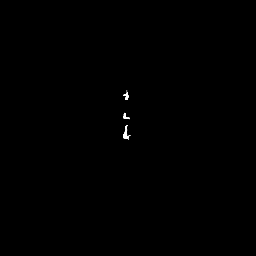

In [23]:
Image.fromarray(masks[100].astype(np.uint8))

In [26]:
masks_pred = masks_pred.cpu().numpy()
print(np.unique(masks_pred))
Image.fromarray(masks_pred[0].astype(np.uint8) * 255)

AttributeError: 'numpy.ndarray' object has no attribute 'cpu'